# 보스턴 주택가격 예측:회귀
회귀는 분류와 다르게 예측 레이블이 연속형으로 출력되어야 함.
데이터가 주어졌을 때 기온이나 가격 등의 수치를 예측하는 것임.

## 보스턴 주택 가격 데이터셋
1970년대 보스턴 지역의 범죄율, 지방세율 등의 변수를 이용해 집값을 예측하는 모델 생성  
Train Data : 404개  
Test Data : 102개  
각 feature의 스케일이 다름  ex) 비율 or  정수형 데이터(1~12,1~100 등)  

In [4]:
import numpy as np

In [5]:
from tensorflow.keras.datasets import boston_housing
(train,train_tg),(test,test_tg)=(boston_housing.load_data())

## Train Data

In [6]:
train.shape

(404, 13)

In [7]:
train_tg.shape

(404,)

# Test Data

In [8]:
test.shape

(102, 13)

In [9]:
test_tg.shape

(102,)

## 데이터 준비
feature별 스케일이 다르면 신경망 알고리즘이 제대로 동작하지 않아 예측이 되지 않음.  
그러므로 정규화를 통해서 feature들의 스케일을 같게 해야함.  
사이킷런의 StandardScaler 함수를 이용해 스케일링 변환

In [10]:
from sklearn.preprocessing import StandardScaler

In [11]:
std=StandardScaler()
X_tr=std.fit_transform(train)
X_te=std.transform(test)

## 모델 구성

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

In [13]:
def build_model():
    model=keras.Sequential([
        layers.Dense(64,activation='relu'),
        layers.Dense(64,activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='rmsprop',
                 loss='mse',
                 metrics='mae')
    return model

# KFold 교차검증
데이터셋이 너무 적을때 사용하는 분할 방법으로 Train과Test 데이터셋을 합쳐도 500여개 밖에 안되므로 일반적인 홀드아웃 방식으로는 학습이 제대로 진행되지 않을 수 있음.  
그러므로 Kfold 방식으로 교차검증을 통해 과적합을 방지함.
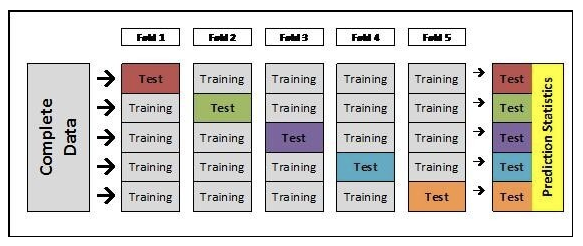

In [14]:
from sklearn.model_selection import KFold

In [15]:
kfold=KFold(n_splits=5)

In [18]:
evaluate=[]
for train_index, val_index in kfold.split(X_tr):
    X_train, X_val = X_tr[train_index], X_tr[val_index]
    y_train, y_val = train_tg[train_index], train_tg[val_index]
    model=build_model()
    model.fit(X_train,y_train,epochs=200,batch_size=16,validation_data=(X_val,y_val),verbose=0)
#     mse_eval=history.history['val_mae']
    val_mse,val_mae=model.evaluate(X_val,y_val)
    
    evaluate.append(val_mae)

3/3 [==============================] - 0s 5ms/step - loss: 16.7500 - mae: 2.4217


In [19]:
evaluate

[1.951420783996582,
 2.4015204906463623,
 2.2422432899475098,
 2.8113436698913574,
 2.4216551780700684]

Kfold 교차검증 성능 mae = 2.37

In [20]:
np.mean(evaluate)

2.365636682510376

## 각 fold별 검증 점수 저장해 출력

In [22]:
fold_eval=[]
for train_index, val_index in kfold.split(X_tr):
    X_train, X_val = X_tr[train_index], X_tr[val_index]
    y_train, y_val = train_tg[train_index], train_tg[val_index]
    model=build_model()
    history=model.fit(X_train,y_train,epochs=200,validation_data=(X_val,y_val),batch_size=16,verbose=0)
    mse_eval=history.history['val_mae']
    fold_eval.append(mse_eval)

In [23]:
mean_mae=[np.mean([j[i] for j in fold_eval]) for i in range(200)]

In [24]:
import matplotlib.pyplot as plt

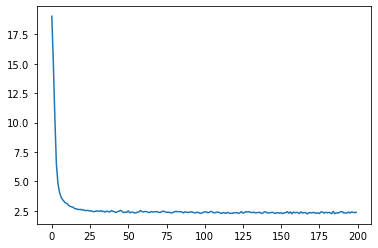

In [25]:
plt.plot(range(200),mean_mae)

epochs가 약 10~15사이에서 완만해지므로 10이후부터 그래프 생성

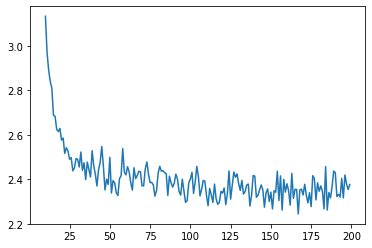

In [26]:
plt.plot(range(10,200),mean_mae[10:])
# 120~130사이에서 다시 증가하는 부분이 존재

In [31]:
model=build_model()
model.fit(train,train_tg,epochs=130,batch_size=16,verbose=0)

In [32]:
te_mse,te_mae=model.evaluate(test,test_tg)

4/4 [==============================] - 0s 4ms/step - loss: 26.4849 - mae: 3.5077


전체데이터로 훈련시킬 경우 다소 성능이 낮아짐.  (Kfold교차 검증에 의한 성능 약 2.37)  
데이터 수가 너무 적으면 교차검증을 통해 성능을 향상 시킬 수 있음.